In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import datetime as dt
from statsmodels.regression.rolling import RollingOLS

In [3]:
''' 데이터 받아오기'''
# 데이터 최신화(2023-06-06)
url = './DATA/'#/Real Raw Data/'

''' FF3F 갈아끼울 것'''
# HML = pd.read_csv(url + 'HML.csv')
# SMB = pd.read_csv(url + 'SMB.csv')
# RM_RF = pd.read_csv(url + 'RM-RF.csv')

kospi_adj_close = pd.read_pickle(url + 'kospi_adj_close.pkl') # 1989.06.01 ~ 2023.06.02 코스피 수정종가 데이터
kospi_capital = pd.read_pickle(url + 'kospi_capital.pkl')
kospi_total_asset = pd.read_pickle(url + 'kospi_total_asset.pkl')
kospi_index = pd.read_csv(url + 'kospi_index.csv')
cd91 = pd.read_csv(url + 'CD91.csv')

In [4]:
''' 총수익률 모멘텀 '''

# daily return
kospi_daily_return = kospi_adj_close.pct_change()
kospi_daily_return

# monthly return
kospi_monthly_return = kospi_daily_return.resample('M').agg(lambda x: (x+1).prod() - 1) # 월단위로 agg한다음 그 안에 값에 대해서 cumprod를 계산하는 방식. 일별 to 월별수익률
kospi_monthly_return = kospi_monthly_return.iloc[:-1] # 2023년 6월 데이터는 아직 모두 존재하지 않음
kospi_monthly_return

,005930,373220,000660,207940,051910,006400,005380,000270,035420,005490,...,114410,117930,121910,122290,122750,138250,144620,152330,192520,192530
1989-06-30,-2.220446e-16,0.000000,0.000000,0.000000,0.000000,-0.045780,-0.064345,0.003936,0.000000,-0.056788,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1989-07-31,1.428571e-01,0.000000,0.000000,0.000000,0.000000,0.143929,0.140924,0.054898,0.000000,0.097003,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1989-08-31,1.102941e-01,0.000000,0.000000,0.000000,0.000000,0.181011,0.051176,0.044612,0.000000,0.048800,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1989-09-30,8.830022e-03,0.000000,0.000000,0.000000,0.000000,-0.041102,-0.022907,0.017795,0.000000,-0.040697,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1989-10-31,-3.938731e-02,0.000000,0.000000,0.000000,0.000000,-0.154007,-0.067446,-0.048952,0.000000,-0.033338,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-31,1.030741e-01,0.196326,0.180000,-0.034105,0.150000,0.159052,0.105960,0.126476,0.140845,0.086799,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-02-28,-6.557377e-03,0.003839,0.010169,-0.025221,-0.014493,0.016058,0.055689,0.127246,0.029630,0.058236,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-03-31,5.610561e-02,0.116635,-0.008949,0.019405,0.047059,0.056034,0.046512,0.075697,-0.031175,0.157233,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-04-30,2.343750e-02,-0.005137,0.010158,-0.008883,0.039326,-0.059864,0.070461,0.043210,-0.048020,0.024457,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
'''t-12 ~ t-1 성과를 바탕으로 t기의 모멘텀 확인 '''
temp = kospi_monthly_return.copy()
mom_rtn = (temp+1.).shift(1).rolling(window=11).apply(lambda x: x.prod(), raw=True) - 1 # 누적수익률 방식

In [45]:
mom_rtn.iloc[np.where(mom_rtn > 7)]

,003830,014160,014160,014160,014160,010420,012750,007610,007610,016450,...,011400,011400,011400,011400,011400,011400,012760,001570,001570,001570
1992-06-30,7.111210,-0.387554,-0.387554,-0.387554,-0.387554,-0.671124,0.000000,0.132597,0.132597,0.000000,...,-0.434146,-0.434146,-0.434146,-0.434146,-0.434146,-0.434146,0.039640,0.627096,0.627096,0.627096
1994-12-31,-0.249572,9.487787,9.487787,9.487787,9.487787,-0.146314,0.000000,0.100888,0.100888,0.000000,...,0.373102,0.373102,0.373102,0.373102,0.373102,0.373102,0.034870,-0.086101,-0.086101,-0.086101
1995-01-31,-0.392018,10.367550,10.367550,10.367550,10.367550,-0.280275,0.000000,0.424850,0.424850,0.000000,...,1.955766,1.955766,1.955766,1.955766,1.955766,1.955766,0.359691,0.057402,0.057402,0.057402
1995-02-28,-0.242540,7.481497,7.481497,7.481497,7.481497,-0.409789,0.000000,0.473684,0.473684,0.000000,...,0.880000,0.880000,0.880000,0.880000,0.880000,0.880000,0.492562,0.263496,0.263496,0.263496
1995-04-30,-0.024884,8.073199,8.073199,8.073199,8.073199,0.000000,0.000000,0.252459,0.252459,0.000000,...,0.807958,0.807958,0.807958,0.807958,0.807958,0.807958,0.372104,0.232903,0.232903,0.232903
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-31,-0.092527,-0.132075,-0.132075,-0.132075,-0.132075,-0.105150,-0.149383,-0.232737,-0.232737,-0.273885,...,529.000000,529.000000,529.000000,529.000000,529.000000,529.000000,2.304130,-0.106299,-0.106299,-0.106299
2022-08-31,-0.245614,-0.351852,-0.351852,-0.351852,-0.351852,-0.271071,-0.222899,-0.220779,-0.220779,-0.334826,...,-0.471302,-0.471302,-0.471302,-0.471302,-0.471302,-0.471302,15.388060,0.508834,0.508834,0.508834
2023-03-31,0.044000,-0.351293,-0.351293,-0.351293,-0.351293,-0.222482,-0.208976,0.000000,0.000000,-0.289747,...,-0.273752,-0.273752,-0.273752,-0.273752,-0.273752,-0.273752,-0.828679,7.200213,7.200213,7.200213
2023-04-30,-0.030588,-0.387826,-0.387826,-0.387826,-0.387826,-0.272422,-0.197388,0.000000,0.000000,-0.342836,...,-0.274717,-0.274717,-0.274717,-0.274717,-0.274717,-0.274717,-0.827273,16.290749,16.290749,16.290749


In [24]:
'''전 기간에 대해 top(short), bottom(long) 포트폴리오 구성'''

top_mom_pfo = pd.DataFrame()
btm_mom_pfo = pd.DataFrame()

for t in range(mom_rtn.T.shape[1]):
#for t in range(2):
        
    
    df_sorted = mom_rtn.T.iloc[:,t].sort_values(ascending=True)

    # 110개씩 구성
    top_pfo_rtn = pd.DataFrame(df_sorted[:int(len(df_sorted)/10)])
    top_pfo = pd.DataFrame(top_pfo_rtn.index, columns=top_pfo_rtn.columns)
    btm_pfo_rtn = pd.DataFrame(df_sorted[int((len(df_sorted) * 9)/10)+1:] )
    btm_pfo = pd.DataFrame(btm_pfo_rtn.index, columns=btm_pfo_rtn.columns)
    
    # 종목 티커 추출 후, 해당 티커들을 월별로 저장
    top_mom_pfo = pd.concat([top_mom_pfo, top_pfo], axis=1)
    btm_mom_pfo = pd.concat([btm_mom_pfo, btm_pfo], axis=1)


In [12]:
mom_rtn.T.shape[1]

408

In [20]:
top_mom_pfo

,1989-06-30,1989-07-31,1989-08-31,1989-09-30,1989-10-31,1989-11-30,1989-12-31,1990-01-31,1990-02-28,1990-03-31,...,2022-08-31,2022-09-30,2022-10-31,2022-11-30,2022-12-31,2023-01-31,2023-02-28,2023-03-31,2023-04-30,2023-05-31
0,005930,005930,005930,005930,005930,005930,005930,005930,005930,005930,...,007630,007630,007630,007630,007630,007630,009280,012760,006380,012760
1,373220,373220,373220,373220,373220,373220,373220,373220,373220,373220,...,030790,030790,004830,377300,030790,101140,101140,003560,012760,101140
2,000660,000660,000660,000660,000660,000660,000660,000660,000660,000660,...,145210,001970,030790,101140,101140,093230,033180,101140,003560,033180
3,207940,207940,207940,207940,207940,207940,207940,207940,207940,207940,...,093230,003580,377300,323410,001210,145210,003560,033180,101140,006380
4,051910,051910,051910,051910,051910,051910,051910,051910,051910,051910,...,015020,145210,003560,302440,377300,033180,093230,011090,033180,003560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,052690,052690,052690,052690,052690,052690,052690,052690,052690,052690,...,042670,372910,001750,001360,214390,005090,001360,008250,339770,013570
106,008930,008930,008930,008930,008930,008930,008930,008930,008930,008930,...,009450,139480,034300,023800,300720,002870,035720,014280,004540,133820
107,001040,001040,001040,001040,001040,001040,001040,001040,001040,001040,...,017180,339770,139990,044820,009900,259960,051630,036580,019170,006200
108,028670,028670,028670,028670,028670,028670,028670,028670,028670,028670,...,013580,005250,000020,072130,034220,025890,007110,352820,012800,011790


In [23]:
df_sorted

005930   NaN
373220   NaN
000660   NaN
207940   NaN
051910   NaN
          ..
138250   NaN
144620   NaN
152330   NaN
192520   NaN
192530   NaN
Name: 1989-07-31 00:00:00, Length: 1102, dtype: float64

In [18]:
kospi_adj_close.loc['1989-06-30'].dropna()

005930         357
006400       18801
005380       17144
000270      199186
005490       27123
            ...   
016160    10157356
016390       12167
016420        9145
016570       15830
017320        8641
Name: 1989-06-30 00:00:00, Length: 443, dtype: object

In [40]:
'''holding period=1m으로 할때'''
''' holding period를 갈아까일 수 있는 방식으로 변경 '''

long_pnl = []
short_pnl = []

for i in range(len(kospi_monthly_return.index)):
#for i in range(0,3):

    #print(kospi_monthly_return.iloc[i,kospi_monthly_return.columns.isin(btm_mom_pfo.iloc[:,i])])
    pnl = kospi_monthly_return.iloc[i,kospi_monthly_return.columns.isin(btm_mom_pfo.iloc[:,i])].mean() #롱
    long_pnl.append(pnl)
    pnl = -1 * kospi_monthly_return.iloc[i,kospi_monthly_return.columns.isin(top_mom_pfo.iloc[:,i])].mean() #숏
    short_pnl.append(pnl)


In [42]:
''' 병합 '''

mom_pnl_df = pd.concat([pd.Series(long_pnl), pd.Series(short_pnl)], axis=1)

mom_pnl_df.set_index(kospi_monthly_return.index, inplace=True)
mom_pnl_df['total'] = mom_pnl_df.iloc[:,0] + mom_pnl_df.iloc[:,1]
mom_pnl_df.columns = ['long','short','total']

<AxesSubplot:>

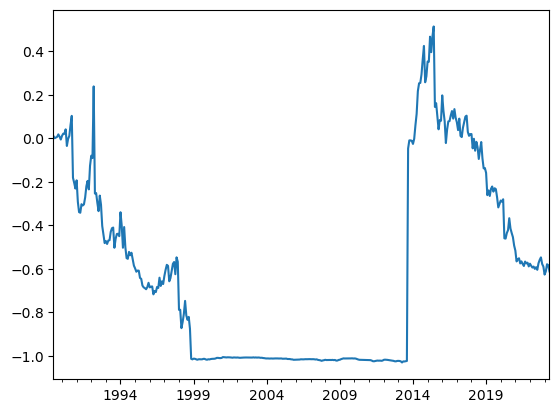

In [43]:
((mom_pnl_df['total'] + 1).cumprod() - 1).plot()

In [73]:
''' FF3F '''

HML = HML.set_index(HML.iloc[:,0])
HML_only = HML['HML']
HML_only.index.rename('date', inplace=True)
# HML_only

SMB = SMB.set_index(SMB.iloc[:,0])
SMB_BM = SMB['SMB_BM']
SMB_BM.index.rename('date', inplace=True)
# SMB_BM

RM_RF.set_index(RM_RF.iloc[:,0], inplace=True)
RM_RF.index.rename('date', inplace=True)
RM_RF = RM_RF.iloc[:,1]
RM_RF.name = 'RM-RF'
# RM_RF

# FF3F 초과수익률
FF3F = pd.concat([RM_RF, SMB_BM, HML_only], axis=1)


# FF3F랑 인덱스 맞춤
ri = kospi_monthly_return[kospi_monthly_return.index.isin(FF3F.dropna().index)]


'''잔차항 계산'''
ff3f_lag = FF3F.shift(1).dropna()
ri_lag = ri.shift(1).dropna()
ri_lag.index = ff3f_lag.index
# ff3f_lag = ff3f_lag.iloc[:,1:] #첫번째 칼럼에 날짜가 중복해서 들어가서 수정

In [75]:
residual_df = pd.DataFrame()

for item in range(len(ri_lag.T)):

    # rolling ols
    # extract epsilon
    model = RollingOLS(ri_lag.iloc[:,item], ff3f_lag, window=35)
    ols = model.fit()
    
    # get residuals
    # t-36~t-1를 통해 추정한 parameter를 t기의 FF3F에 곱해준 뒤, t기의 수익률에 빼서 residual을 계산한다.
    rolling_resid = pd.DataFrame(ri.iloc[:,item].iloc[35:].values - (FF3F.dropna() * ols.params.dropna()).dropna().sum(axis=1).values, index=ri.index[35:], columns=['Rolling_resid'])
    # ri.iloc[:,item].iloc[34:] - (FF3F * ols.params.dropna()).sum(axis=1).iloc[34:]
    residual_df = pd.concat([residual_df, rolling_resid], axis=1)
    
residual_df.columns = ri.columns

/opt/homebrew/Caskroom/miniforge/base/envs/quant/lib/python3.8/site-packages/statsmodels/regression/rolling.py:272: RuntimeWarning: divide by zero encountered in log
  llf = -np.log(ssr) * nobs2  # concentrated likelihood
/opt/homebrew/Caskroom/miniforge/base/envs/quant/lib/python3.8/site-packages/statsmodels/regression/rolling.py:272: RuntimeWarning: divide by zero encountered in log
  llf = -np.log(ssr) * nobs2  # concentrated likelihood
/opt/homebrew/Caskroom/miniforge/base/envs/quant/lib/python3.8/site-packages/statsmodels/regression/rolling.py:272: RuntimeWarning: divide by zero encountered in log
  llf = -np.log(ssr) * nobs2  # concentrated likelihood
/opt/homebrew/Caskroom/miniforge/base/envs/quant/lib/python3.8/site-packages/statsmodels/regression/rolling.py:272: RuntimeWarning: divide by zero encountered in log
  llf = -np.log(ssr) * nobs2  # concentrated likelihood
/opt/homebrew/Caskroom/miniforge/base/envs/quant/lib/python3.8/site-packages/statsmodels/regression/rolling.py:2

In [76]:
residual_df

,005930,373220,000660,207940,051910,006400,005380,000270,035420,005490,...,114410,117930,121910,122290,122750,138250,144620,152330,192520,192530
2003-05-31,0.000934,0.000000,-0.006173,0.000000,-0.005770,-0.052545,-0.115774,-0.035966,0.168329,-0.020031,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00
2003-06-30,0.031625,0.000000,0.420583,0.000000,0.044079,0.121607,0.055897,-0.033976,0.129971,0.121294,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00
2003-07-31,0.110039,0.000000,0.186202,0.000000,-0.052933,0.166997,0.082938,0.011756,0.299175,0.118262,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00
2003-08-31,-0.016151,0.000000,-0.099353,0.000000,-0.007230,-0.035451,0.036149,-0.019462,-0.118119,-0.073573,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00
2003-09-30,-0.001498,0.000000,-0.039449,0.000000,-0.167825,-0.024644,-0.115294,-0.105570,-0.124538,-0.011335,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-31,0.013538,0.132313,0.097349,-0.106378,0.038512,0.046474,0.029478,0.056171,0.054661,0.006068,...,1.032333e-18,2.468823e-18,-1.571925e-18,-2.327687e-18,-5.230249e-18,-0.052423,-0.064940,-0.023824,-7.622280e-19,1.848195e-18
2023-02-28,-0.000239,0.006608,0.014373,-0.033230,-0.002674,0.016017,0.062964,0.126790,0.009642,0.068316,...,2.132642e-20,3.004821e-17,7.096705e-18,6.321747e-19,4.178646e-18,-0.011874,-0.012397,0.004277,-2.163500e-18,6.419282e-18
2023-03-31,0.007594,0.074433,-0.064236,-0.025217,0.015065,-0.013600,0.025235,0.072336,-0.096462,0.190727,...,3.017677e-19,7.406500e-17,3.116183e-18,-2.309357e-18,1.537138e-18,-0.020172,-0.004198,0.001291,-6.095495e-18,1.558260e-17
2023-04-30,0.016974,-0.008801,0.004295,-0.007391,0.019027,-0.059563,0.064222,0.043970,-0.032546,0.002956,...,9.344549e-20,-4.373438e-17,-7.615896e-18,-5.010148e-19,-5.163817e-18,0.010627,0.006829,-0.006435,3.211681e-18,-9.063486e-18


In [119]:
# t-12 ~ t-1 누적수익률(표준화 진행)
cumulative_residual_df = ((residual_df+1).rolling(11).apply(np.prod) - 1)/residual_df.rolling(11).std() 

# 극값 통제
cumulative_residual_df = cumulative_residual_df.replace([np.inf, -np.inf], 0)


# 2004년 3월부터 값이 있는 종목만 선별
resi_window = 11
selected_firms = cumulative_residual_df.iloc[resi_window-1:,:].dropna(axis=1).columns
final_resi_df = cumulative_residual_df.loc[:,selected_firms].dropna(axis=0)

In [158]:
long_pnl = []
short_pnl = []


for i in range(len(final_resi_df.index)):
    top_threshold = final_resi_df.iloc[i,:].sort_values(ascending=False).quantile(0.9)
    btm_threshold = final_resi_df.iloc[i,:].sort_values(ascending=False).quantile(0.1)
    
    # winner, loser 종목 추출
    rsmom_winner = final_resi_df.T[final_resi_df.T.iloc[:,0] > top_threshold].index
    rsmom_loser = final_resi_df.T[final_resi_df.T.iloc[:,0] < btm_threshold].index
    
    # t-1기에서 선정한 위너와 루저를 바탕으로 ri df에서 t기의 수익률 값 추출
    # equal weight로 long-short 구성
    long_pnl.append(ri.iloc[i,ri.columns.isin(rsmom_winner)].mean())
    short_pnl.append(-ri.iloc[i,ri.columns.isin(rsmom_loser)].mean())
    # short_pnl.append(ri.iloc[:,ri.columns.isin(rsmom_loser.index)].iloc[1].values.mean())

In [171]:
rsmom_loser

Index(['003490', '030200', '006800', '021240', '016360', '005940', '001450',
       '000990', '001570', '006360',
       ...
       '010510', '015110', '016420', '016510', '018570', '025930', '027460',
       '027840', '032390', '067250'],
      dtype='object', length=108)

In [172]:
rsmom_winner

Index(['005930', '006400', '035420', '005490', '003670', '066570', '055550',
       '010950', '047050', '018880',
       ...
       '006290', '007050', '007190', '007410', '010330', '014040', '015880',
       '016570', '018410', '024870'],
      dtype='object', length=109)

In [159]:
# total long-short pnl 구성
long_short_pnl = pd.concat([pd.Series(long_pnl), pd.Series(short_pnl)], axis=1)
long_short_pnl = pd.DataFrame(long_short_pnl.iloc[:,0] + long_short_pnl.iloc[:,1])
long_short_pnl.columns= ['RSMOM']
long_short_pnl.set_index(final_resi_df.index, inplace=True)

long_pnl = pd.DataFrame(long_pnl)
long_pnl.columns= ['RSMOM_long_only']
long_pnl.set_index(final_resi_df.index, inplace=True)

short_pnl = pd.DataFrame(short_pnl)
short_pnl.columns= ['RSMOM_short_only']
short_pnl.set_index(final_resi_df.index, inplace=True)

In [168]:
(-1*short_pnl+1).cumprod() - 1

,RSMOM_short_only
2004-03-31,0.033750
2004-04-30,-0.038334
2004-05-31,0.024473
2004-06-30,-0.016136
2004-07-31,-0.177001
...,...
2023-01-31,55.268177
2023-02-28,52.991848
2023-03-31,54.463001
2023-04-30,51.725073


In [160]:
long_short_pnl

,RSMOM
2004-03-31,0.041601
2004-04-30,0.046468
2004-05-31,0.211805
2004-06-30,0.044443
2004-07-31,0.082997
...,...
2023-01-31,-0.018785
2023-02-28,-0.012159
2023-03-31,-0.011837
2023-04-30,-0.005342


<Axes: >

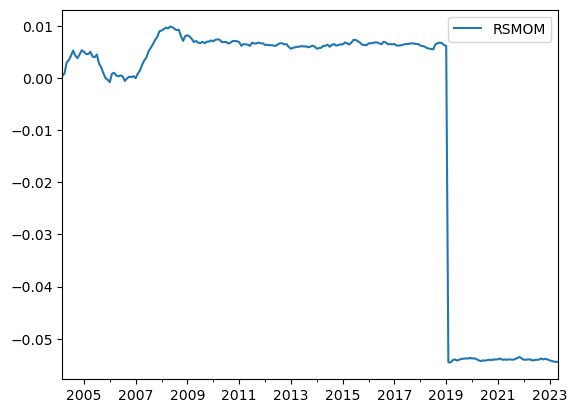

In [161]:
(((long_short_pnl/100) + 1).cumprod() - 1).plot()

<Axes: >

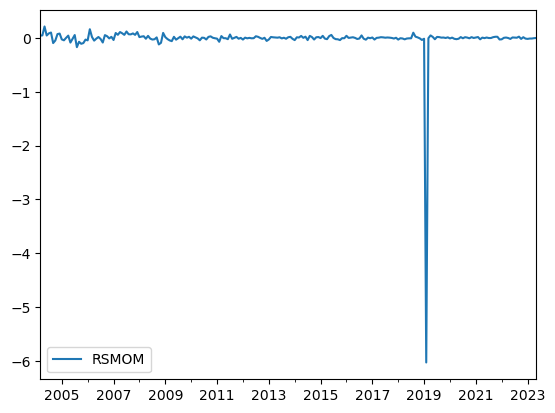

In [162]:
long_short_pnl.plot()

<Axes: >

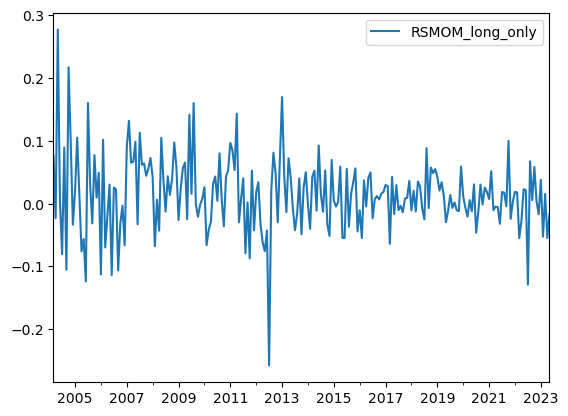

In [163]:
long_pnl.plot()

<Axes: >

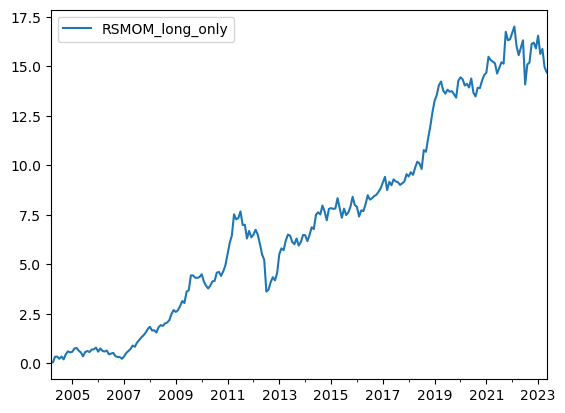

In [164]:
((long_pnl+1).cumprod() - 1).plot()

<Axes: >

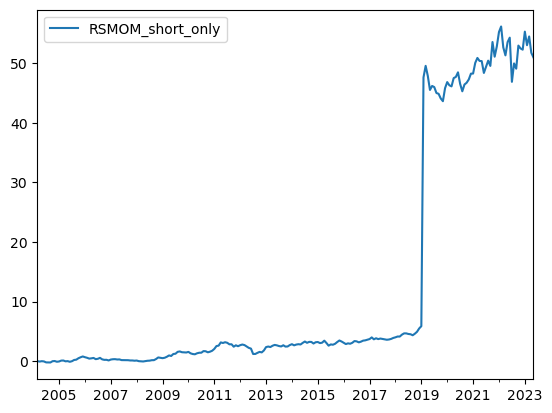

In [173]:
((-1*short_pnl+1).cumprod() - 1).plot()